In [289]:
if (!require(pacman)) install.packages(pacman)
require(pacman)

In [290]:
p_load(
  rio,         # Importar/exportar datos
  tidyverse,   # Manejo de datos ordenados (incluye dplyr, ggplot2, tidyr, readr, etc.)
  skimr,       # Resúmenes rápidos de datos
  gridExtra,   # Visualización de datos faltantes y organizar gráficos en cuadrículas
  corrplot,    # Gráficos de correlación
  stargazer,   # Tablas y salida para LaTeX
  MASS,        # Cálculos posteriores a la regresión y distribuciones estadísticas
  rvest,       # Web scraping
  httr,        # Realizar solicitudes HTTP (APIs y scraping)
  boot,        # Herramientas para Bootstrap y remuestreo estadístico
  broom,       # Convertir resultados de modelos a data frames ordenados
  lmtest,      # Pruebas estadísticas para modelos lineales
  fixest,      # Estimadores con efectos fijos (modelos lineales avanzados)
  sandwich,    # Estimaciones de varianza robusta
  future,      # Paralelización y ejecución asincrónica
  future.apply,# Versión paralela de funciones de `apply`
  furrr,       # Versión paralela de funciones de purrr
  memoise,     # Funciones con caché para evitar cálculos repetitivos
  parallel,    # Soporte para programación paralela
  foreach,     # Estructura para bucles paralelos
  doParallel,  # Backend para ejecutar `foreach` en paralelo
  caret        # Herramientas para la creación de modelos predictivos
)

In [291]:
seed <- 555

### Web Scrapping

In [292]:
plan(multisession) # Paralellizing

urls    <- paste0('https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_',1:10,'.html') # nolint
c_geih  <- future_lapply(
        urls,# nolint
        function(url){# nolint  
                html <- read_html(url)# nolint  
                return((html_node(html, "table") %>% html_table()))# nolint  
                })# nolint  

geih <- do.call(rbind, c_geih)
colnames(geih)[colnames(geih) == "" | is.na(colnames(geih))] <- "index"

### Limpieza

In [293]:
geih  <- geih %>%
            filter(                             # nolint
            age > 18 &                          # nolint
            ocu == 1 &                          # nolint
            !is.na(y_ingLab_m_ha) &                # nolint
            !is.na(age)) %>%
            mutate(log_wage = log(y_ingLab_m_ha + 1))  # nolint

In [294]:
# Crear variable dicotómica para p6580 (bonificaciones recibidas el mes pasado)
geih$bonif <- ifelse(geih$p6580 == 1, 1, ifelse(geih$p6580 == 2, 0, NA))

# Crear variable dicotómica para y_horasExtras_m (ingreso por horas extras)
geih$extra_h <- ifelse(geih$y_horasExtras_m > 0, 1, 0)

# Crear variable dicotómica para p7472 (ingresos por trabajo en desocupados)
geih$desoc <- ifelse(geih$p7472 == 1, 1, 0)

#Currently sex = 1 if Male, we need to invert this variable
geih$sex <- ifelse(geih$sex == 0, 1, 0)

# Cambiar los ingresos a millones
geih$ingtotob <- geih$ingtotob / 1000000

## Limpieza de la educación
geih <- geih %>% filter(!(p6210s1 %in% c(99, 98)))

## Estimación sugerida

In [295]:
age_wage_profile <- lm(log_wage ~ age + I(age^2), data = geih)

In [296]:
fit_model <- function(data, indices) {
    fit <- lm(log_wage ~ age + I(age^2), data = data[indices, ])
    coef(fit)
}

In [297]:
set.seed(seed)
boot_results <- boot(data = geih, statistic = fit_model, R = 1000)
boot_se <- apply(boot_results$t, 2, sd)


peak_age <- -coef(age_wage_profile)[2] / (2 * coef(age_wage_profile)[3])
peak_age_ci <- quantile(boot_results$t[, 2], c(0.025, 0.975))

# Calcular la edad pico y su intervalo de confianza
peak_age <- -coef(age_wage_profile)[2] / (2 * coef(age_wage_profile)[3])
peak_age_ci <- c(
    peak_age-quantile(boot_results$t[, 2],0.025),
    peak_age+quantile(boot_results$t[, 2],0.975))

# Generar predicciones para una secuencia de edades con intervalos de confianza
age_range <- seq(min(geih$age), max(geih$age), length.out = 100)
predicted_values <- predict(age_wage_profile, newdata = data.frame(age = age_range), interval = "confidence")

In [298]:
# Guardar el resultado en un archivo .tex
stargazer(age_wage_profile,
    se = list(boot_se), 
    type = "latex",
    title = "Age-Wage Profile Regression Results",
    column.labels = c("Coefficients", "Bootstrap SE"),
    omit.stat = c("rsq", "adj.rsq", "f", "ser"),
    out = "age_wage_profile_results.tex"  # Guardar en archivo .tex
)
# Mostrar el análisis de la edad pico
cat("\nPeak Age Analysis:\n")
cat("Estimated Peak Age:", round(peak_age, 2), "\n")
cat("95% CI for Peak Age:", round(peak_age_ci[1], 2), "to", round(peak_age_ci[2], 2), "\n\n")


% Table created by stargazer v.5.2.3 by Marek Hlavac, Social Policy Institute. E-mail: marek.hlavac at gmail.com
% Date and time: Sun, Sep 15, 2024 - 21:06:41
\begin{table}[!htbp] \centering 
  \caption{Age-Wage Profile Regression Results} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{1}{c}{\textit{Dependent variable:}} \\ 
\cline{2-2} 
\\[-1.8ex] & log\_wage \\ 
 & Coefficients \\ 
\hline \\[-1.8ex] 
 age & 0.065$^{***}$ \\ 
  & (0.004) \\ 
  & \\ 
 I(age$\hat{\mkern6mu}$2) & $-$0.001$^{***}$ \\ 
  & (0.0001) \\ 
  & \\ 
 Constant & 7.426$^{***}$ \\ 
  & (0.076) \\ 
  & \\ 
\hline \\[-1.8ex] 
Observations & 9,784 \\ 
\hline 
\hline \\[-1.8ex] 
\textit{Note:}  & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\ 
\end{tabular} 
\end{table} 

Peak Age Analysis:
Estimated Peak Age: 45.32 
95% CI for Peak Age: 45.27 to 45.4 



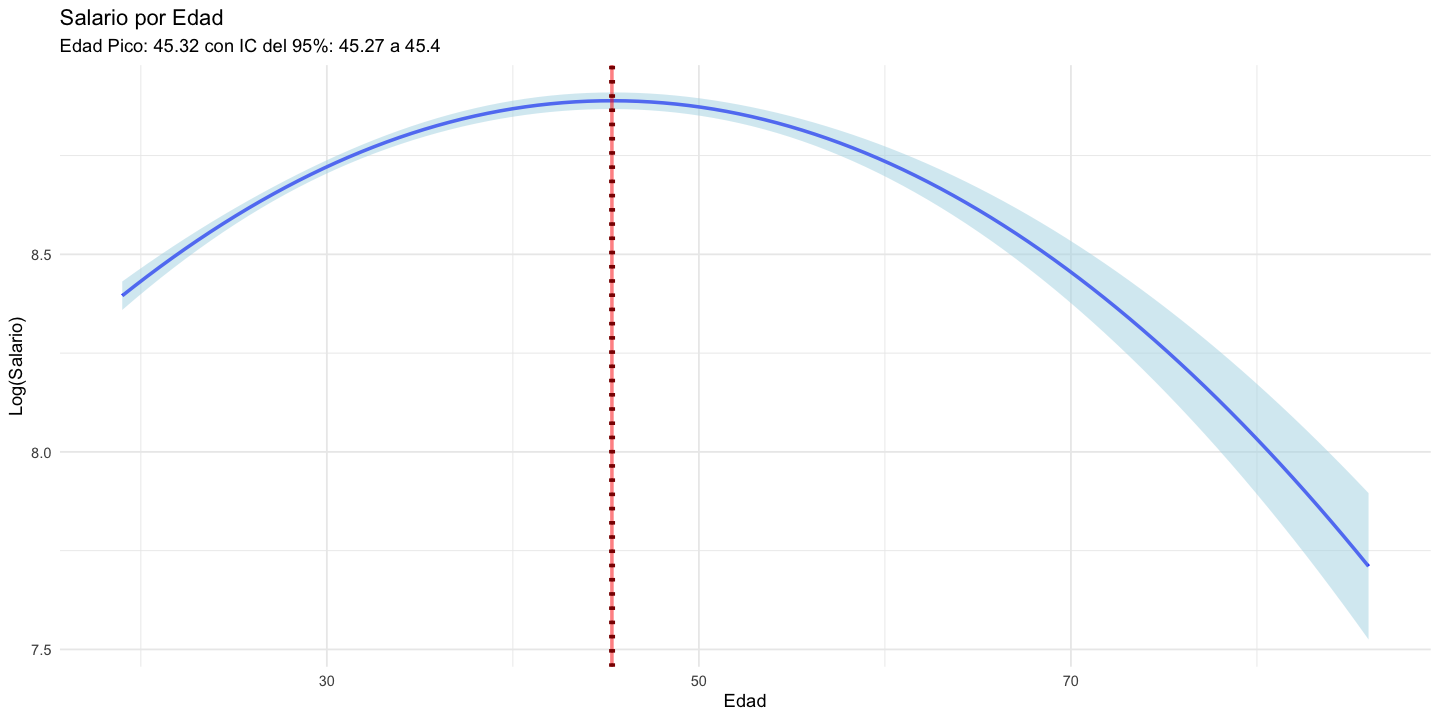

In [314]:
geih_plot <- data.frame(
  edad = age_range,
  salario_logaritmico_estimado = predicted_values[, "fit"],
  inferior = predicted_values[, "lwr"],
  superior = predicted_values[, "upr"]
)

# Gráfico del perfil de ingresos por edad con intervalos de confianza
options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(geih_plot, aes(x = edad, y = salario_logaritmico_estimado)) +
  geom_line(color = "blue", size = 1) +  # Curva de predicción
  geom_ribbon(aes(ymin = inferior, ymax = superior), fill = "lightblue", alpha = 0.5) +  # Intervalo de confianza
  geom_vline(xintercept = peak_age, color = "red", size = 1, alpha = 0.5) +  # Línea de la edad pico
  geom_vline(xintercept = peak_age_ci[1], linetype = "dotted", color = "darkred", size = 1) +  # CI inferior
  geom_vline(xintercept = peak_age_ci[2], linetype = "dotted", color = "darkred", size = 1) +  # CI superior
  labs(
    title = "Salario por Edad",
    subtitle = paste("Edad Pico:", round(peak_age, 2), "con IC del 95%:", round(peak_age_ci[1], 2), "a", round(peak_age_ci[2], 2)),
    x = "Edad",
    y = "Log(Salario)"
  ) +
  theme_minimal()

### Predicting Earnings

In [300]:
# Variables categ
geih$maxEducLevel <- as.factor(geih$maxEducLevel)
geih$sex <- as.factor(geih$sex)
geih$formal <- as.factor(geih$formal)
geih$sizeFirm <- as.factor(geih$sizeFirm)
geih$cotPension <- as.factor(geih$cotPension)
geih$depto <- as.factor(geih$depto)
geih$desoc <- as.factor(geih$desoc)
geih$extra_h <- as.factor(geih$extra_h)
geih$bonif <- as.factor(geih$bonif)
geih$estrato1 <- as.factor(geih$estrato1)

In [301]:
training_size <- floor(0.7 * nrow(geih))
training_index <- sample(seq_len(nrow(geih)), size = training_size)

training_set <- geih[training_index, ]
test_set <- geih[-training_index, ]

In [302]:
generar_modelos <- function(variables, respuesta = "y", max_polinomio = 2, tipo_variable) {

  todas_las_variables <- c()

  # Polinomios
  for (var in variables) {
    if (tipo_variable[[var]] == "continua") {
      todas_las_variables <- c(todas_las_variables, var)
      for (grado in 2:max_polinomio) {
        polinomio_var <- paste("I(", var, "^", grado, ")", sep = "")
        todas_las_variables <- c(todas_las_variables, polinomio_var)
      }
    } else if (tipo_variable[[var]] %in% c("categorica", "dicotoma")) {
      todas_las_variables <- c(todas_las_variables, var)
    }
  }

  # Formulas
  lista_modelos <- c()
  
  # Iteración
  for (num_var in 1:length(todas_las_variables)) {
    combinaciones <- combn(todas_las_variables, num_var, simplify = FALSE)
    
    # Crear formulas
    for (comb in combinaciones) {
      formula <- paste(respuesta, "~", paste(comb, collapse = " + "))
      lista_modelos <- c(lista_modelos, formula)
    }
  }
  return(lista_modelos)
}

In [303]:
variables <- c("maxEducLevel", "hoursWorkUsual", "sex", "age", "formal", "sizeFirm", "cotPension", "depto", "desoc", "extra_h", "bonif", "estrato1")
tipo_variable <- list(
  "maxEducLevel" = "categorica",
  "hoursWorkUsual" = "continua",
  "sex" = "dicotoma",
  "age" = "continua",
  "formal" = "dicotoma",
  "sizeFirm" = "categorica",
  "cotPension" = "categorica",
  "depto" = "categorica",
  "desoc" = "dicotoma",
  "extra_h" = "dicotoma",
  "bonif" = "dicotoma",
  "estrato1" = "categorica"
)


lista_modelos <- generar_modelos(variables, respuesta = "log_wage", max_polinomio = 3, tipo_variable)

length(lista_modelos)

[1] 65535

In [304]:

plan(multisession)


resultados_modelos <- data.frame(modelo = character(), rmse = numeric(), stringsAsFactors = FALSE)
resultados_paralelos <- future_lapply(lista_modelos, function(modelo_formula) {
  
  # Estimar
  modelo <- tryCatch({
    lm(as.formula(modelo_formula), data = training_set)
  }, error = function(e) return(NULL))
  
  if (!is.null(modelo)) {
    # Predecir
    predicciones <- tryCatch({
      predict(modelo, newdata = test_set)
    }, error = function(e) return(NA))
    
    
    if (!any(is.na(predicciones))) {
      # Calcular RMSE
      rmse <- sqrt(mean((test_set[['log_wage']] - predicciones)^2))
    } else {
      rmse <- NA
    }
    

    return(data.frame(modelo = modelo_formula, rmse = rmse, stringsAsFactors = FALSE))
    
  } else {
  
    return(data.frame(modelo = modelo_formula, rmse = NA, stringsAsFactors = FALSE))
  }
}, future.seed = TRUE)  


resultados_modelos <- do.call(rbind, resultados_paralelos)
resultados_modelos <- na.omit(resultados_modelos[order(resultados_modelos$rmse), ])

resultados_modelos$orden <- nrow(resultados_modelos):1
resultados_modelos$top <- paste('Modelo',1:nrow(resultados_modelos))


print(resultados_modelos[1:5,])

                                                                                                                                                                 modelo
60697                  log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + sizeFirm + cotPension + bonif + estrato1
64029         log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + formal + sizeFirm + cotPension + bonif + estrato1
53746                             log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + sizeFirm + cotPension + bonif + estrato1
63063 log_wage ~ maxEducLevel + hoursWorkUsual + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + sizeFirm + cotPension + bonif + estrato1
60732                    log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + formal + sizeFirm + cotPension + bonif + e

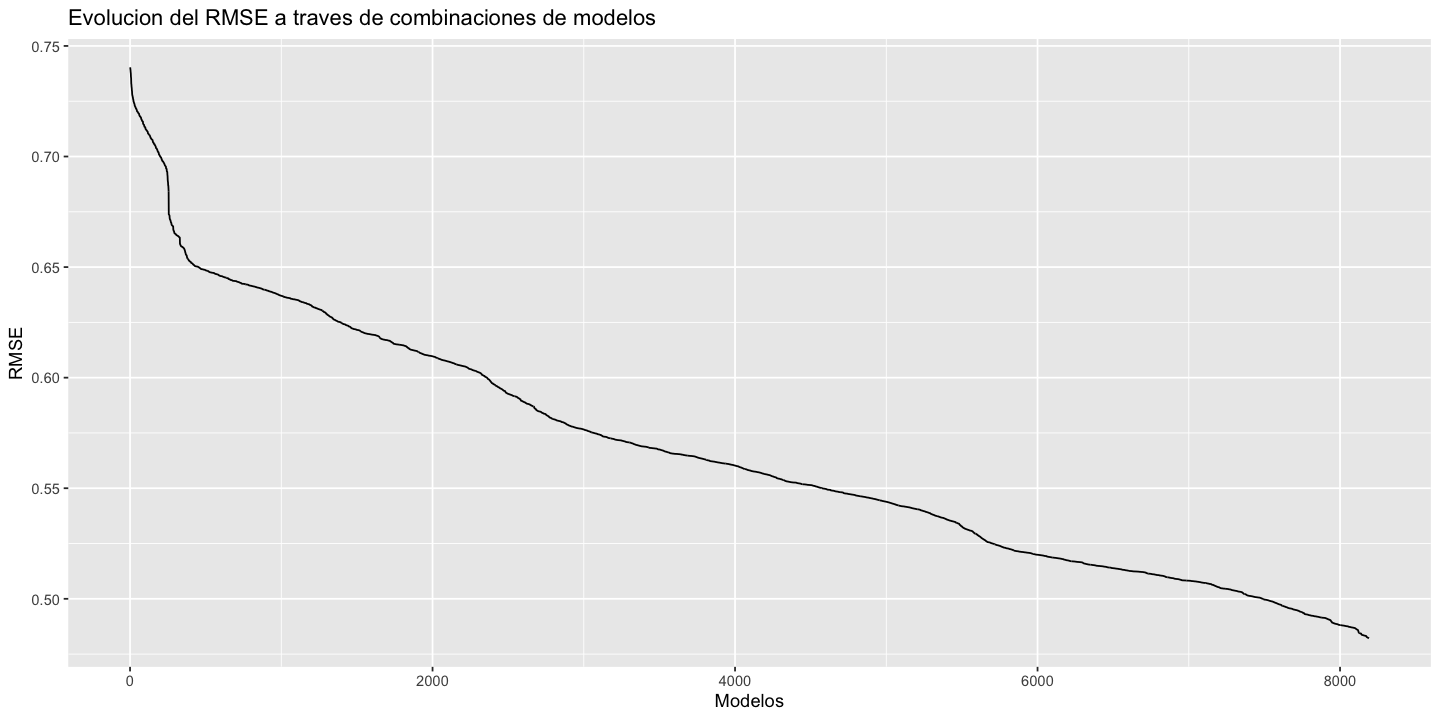

In [305]:
resultados_modelos <- resultados_modelos[order(resultados_modelos$rmse), ]



ggplot(resultados_modelos, aes(x = orden, y = rmse)) +
  geom_line( size = .5) +  
  labs(title = "Evolucion del RMSE a traves de combinaciones de modelos",
       x = "Modelos",
       y = "RMSE") 

In [306]:
resultados_modelos <- resultados_modelos[order(resultados_modelos$rmse), ][1:5,]

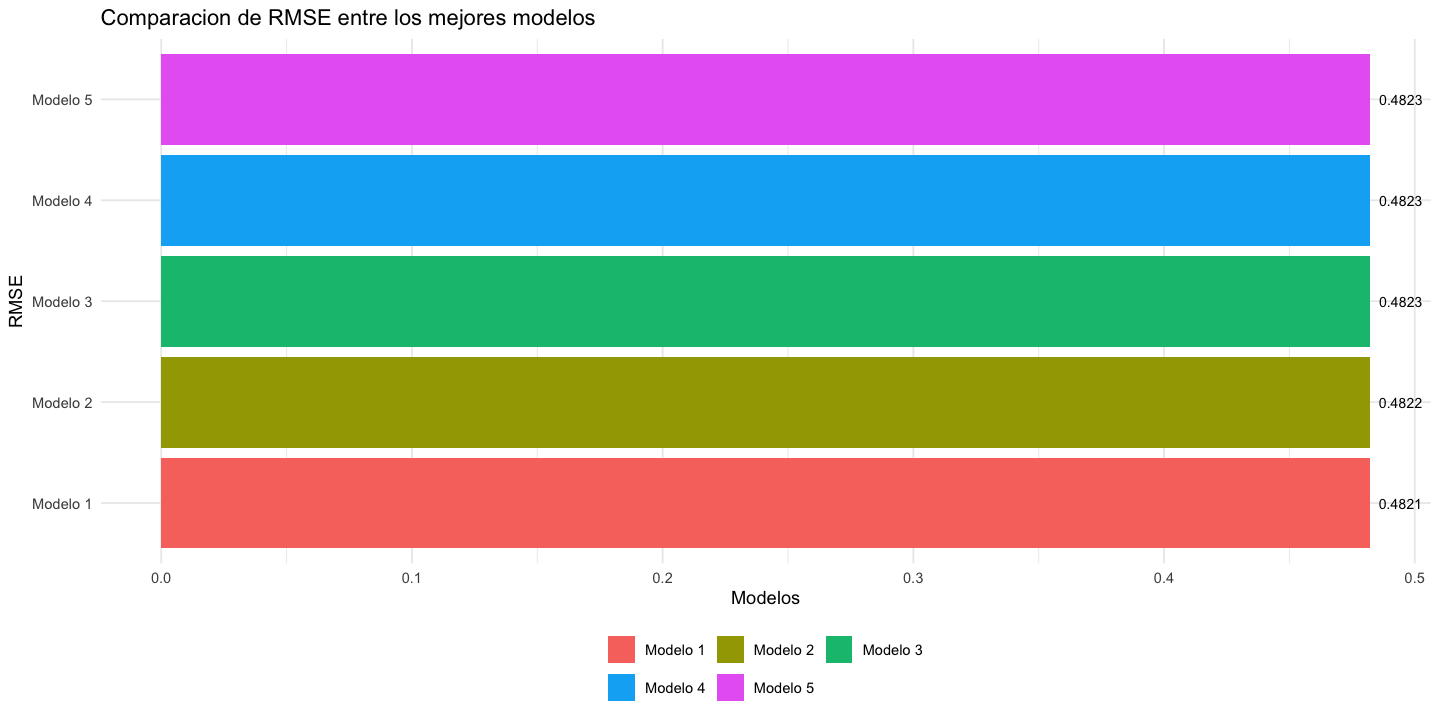

In [307]:

ggplot(resultados_modelos, aes(x = reorder(top, rmse), y = rmse, fill=top)) +
  geom_bar(stat = "identity") +
  coord_flip() +  
  geom_text(aes(label = round(rmse, 4)),  
            hjust = -0.2,  
            size = 3) + 
  theme_minimal() +
  labs(title = "Comparacion de RMSE entre los mejores modelos", 
       x = "RMSE", 
       y = "Modelos") +
  theme(legend.position = "bottom",  
        legend.title = element_blank()) +  
  guides(fill = guide_legend(nrow = 2, byrow = TRUE))  

In [308]:
lista_modelos <- resultados_modelos$modelo

rmse_1 <- rmse_2 <- rmse_3 <- rmse_4 <- rmse_5 <- NA

# Re-estimar los modelos y calcular el RMSE
model_1 <- lm(as.formula(lista_modelos[1]), data = training_set)
pred_1 <- predict(model_1, newdata = test_set)
rmse_1 <- sqrt(mean((test_set[['log_wage']] - pred_1)^2))

model_2 <- lm(as.formula(lista_modelos[2]), data = training_set)
pred_2 <- predict(model_2, newdata = test_set)
rmse_2 <- sqrt(mean((test_set[['log_wage']] - pred_2)^2))

model_3 <- lm(as.formula(lista_modelos[3]), data = training_set)
pred_3 <- predict(model_3, newdata = test_set)
rmse_3 <- sqrt(mean((test_set[['log_wage']] - pred_3)^2))

model_4 <- lm(as.formula(lista_modelos[4]), data = training_set)
pred_4 <- predict(model_4, newdata = test_set)
rmse_4 <- sqrt(mean((test_set[['log_wage']] - pred_4)^2))

model_5 <- lm(as.formula(lista_modelos[5]), data = training_set)
pred_5 <- predict(model_5, newdata = test_set)
rmse_5 <- sqrt(mean((test_set[['log_wage']] - pred_5)^2))


In [309]:
print(resultados_modelos)

                                                                                                                                                                 modelo
60697                  log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + sizeFirm + cotPension + bonif + estrato1
64029         log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + formal + sizeFirm + cotPension + bonif + estrato1
53746                             log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + sizeFirm + cotPension + bonif + estrato1
63063 log_wage ~ maxEducLevel + hoursWorkUsual + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + I(age^3) + sizeFirm + cotPension + bonif + estrato1
60732                    log_wage ~ maxEducLevel + I(hoursWorkUsual^2) + I(hoursWorkUsual^3) + sex + age + I(age^2) + formal + sizeFirm + cotPension + bonif + e

In [315]:
predicciones <- predict(model_1, newdata = test_set)
errores <- test_set$log_wage - predicciones
summary(errores)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-2.753003 -0.268670 -0.013822 -0.002407  0.256713  2.708530 

### LOOCV

In [340]:
lista_modelos <- resultados_modelos$modelo[1:2]

rmse_1 <- rmse_2 <- NA

model_1 <- lm(as.formula(lista_modelos[1]), data = training_set)
pred_1 <- predict(model_1, newdata = test_set)
rmse_1 <- sqrt(mean((test_set[['log_wage']] - pred_1)^2))

model_2 <- lm(as.formula(lista_modelos[2]), data = training_set)
pred_2 <- predict(model_2, newdata = test_set)
rmse_2 <- sqrt(mean((test_set[['log_wage']] - pred_2)^2))

rmse_test_set <- data.frame(
  Model = c("Modelo 1", "Modelo 2"),
  RMSE = c(rmse_1, rmse_2)
)

print(rmse_test_set)

ctrl <- trainControl(method = "LOOCV")
geih <- geih[!is.na(geih$bonif), ]

model_1_loocv <- train(as.formula(lista_modelos[1]), data = geih, method = 'lm', trControl = ctrl)
rmse_1_loocv <- sqrt(mean((model_1_loocv$pred$pred - geih$log_wage)^2))

model_2_loocv <- train(as.formula(lista_modelos[2]), data = geih, method = 'lm', trControl = ctrl)
rmse_2_loocv <- sqrt(mean((model_2_loocv$pred$pred - geih$log_wage)^2))

rmse_comparison <- data.frame(
  Model = c("Modelo 1: Test Set", "Modelo 1: LOOCV",
            "Modelo 2: Test Set", "Modelo 2: LOOCV"),
  RMSE = c(rmse_1, rmse_1_loocv,
           rmse_2, rmse_2_loocv)
)

print(rmse_comparison)
```​⬤

     Model      RMSE
1 Modelo 1 0.4821370
2 Modelo 2 0.4821716
               Model      RMSE
1 Modelo 1: Test Set 0.4821370
2    Modelo 1: LOOCV 0.4746573
3 Modelo 2: Test Set 0.4821716
4    Modelo 2: LOOCV 0.4746896


In [343]:
model_1 <- lm(as.formula(lista_modelos[1]), data = geih)
X_1 <- model.matrix(model_1)
y_1 <- model.response(model.frame(model_1))
A_1 <- solve(t(X_1) %*% X_1)
vec_1 <- 1 / (1 - hatvalues(model_1))
N_1 <- nrow(X_1)
LOO_1 <- numeric(N_1)

for (i in 1:N_1) {
  new_beta_1 <- model_1$coefficients - vec_1[i] * model_1$residuals[i] * A_1 %*% as.vector(X_1[i, ])
  new_error_1 <- (y_1[i] - (X_1[i, ] %*% new_beta_1))^2
  LOO_1[i] <- new_error_1
}

looCV_error_1 <- mean(LOO_1)
rmse_1_loocv <- sqrt(looCV_error_1)

model_2 <- lm(as.formula(lista_modelos[2]), data = geih)
X_2 <- model.matrix(model_2)
y_2 <- model.response(model.frame(model_2))
A_2 <- solve(t(X_2) %*% X_2)
vec_2 <- 1 / (1 - hatvalues(model_2))
N_2 <- nrow(X_2)
LOO_2 <- numeric(N_2)

for (i in 1:N_2) {
  new_beta_2 <- model_2$coefficients - vec_2[i] * model_2$residuals[i] * A_2 %*% as.vector(X_2[i, ])
  new_error_2 <- (y_2[i] - (X_2[i, ] %*% new_beta_2))^2
  LOO_2[i] <- new_error_2
}

looCV_error_2 <- mean(LOO_2)
rmse_2_loocv <- sqrt(looCV_error_2)

rmse_comparison <- data.frame(
  Model = c("Modelo 1: Test Set", "Modelo 1: LOOCV",
            "Modelo 2: Test Set", "Modelo 2: LOOCV"),
  RMSE = c(rmse_1, rmse_1_loocv,
           rmse_2, rmse_2_loocv)
)

print(rmse_comparison)

               Model      RMSE
1 Modelo 1: Test Set 0.4821370
2    Modelo 1: LOOCV 0.4746573
3 Modelo 2: Test Set 0.4821716
4    Modelo 2: LOOCV 0.4746896
